# SSN2V

In [9]:
# do...
s1 = False
s2 = False

## Load Model

In [10]:
from ssn2v.models.enhanced_n2v_unet import get_e_n2n_unet_model
import torch

model = get_e_n2n_unet_model()
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

print(model)

EnhancedNoiseToVoidUNet(
  (downs): ModuleList(
    (0): ResDoubleConv(
      (residual): Sequential(
        (0): Conv2d(1, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (double_conv): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (activation): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): ResDoubleConv(
      (residual): Sequential(
        (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (double_conv): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_ru

## Stage 1

In [11]:
from ssn2v.stage1.run import run_stage1

In [12]:
stage1_config = {
    "train": True,
    "test": False,
    "evaluate": False,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "model": model,
    "model_config": {
        "input_channels": 1,
        "output_channels": 1,
        "num_filters": 32,
        "num_layers": 4,
        "kernel_size": 3,
        "activation": "relu",
        "dropout_rate": 0.5,
    },
    "train_config": {
        "batch_size": 16,
        "learning_rate": 0.001,
        "num_epochs": 20,
        "loss_function": "mse",
        "optimizer": torch.optim.Adam(model.parameters(), lr=1e-3),
        "scheduler": "step_lr",
        "scheduler_step_size": 10,
        "criterion": torch.nn.MSELoss(),
        "early_stopping": True,
        "early_stopping_patience": 5,
        "early_stopping_delta": 0.01,
        "stage1_checkpoint_path": rf'ssn2v/checkpoints/stage1_model.pth',
        "stage2_checkpoint_path": rf'ssn2v/checkpoints/stage2_model.pth',
        "scratch": False,
        "visualise": True,
        "mask_ratio": 0.5,
    },
    "data_config": {
        "regular" : True, # type of preprocessing
        "img_size": (256), #square img
        "num_patients" : 2, # minimum of 2 
        "img_per_patient" : 50,
        "train_data_path": "./data/train",
        "val_data_path": "./data/val",
        "test_data_path": "./data/test",
        "post_process_size" : 40,
        "threshold" : 80,
        "n_neighbours" : 2,
        "background_thresh" : 0.05

    },
    
}

if s1:
    model, history, train_loader, val_loader, test_loader = run_stage1(stage1_config)


## Stage 2

In [13]:
from ssn2v.stage2.run import run_stage2

In [ ]:
config = {
    "train": True,
    "test": False,
    "evaluate": False,
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "model": model,
    "model_config": {
        "input_channels": 1,
        "output_channels": 1,
        "num_filters": 32,
        "num_layers": 4,
        "kernel_size": 3,
        "activation": "relu",
        "dropout_rate": 0.5,
    },
    "train_config": {
        "batch_size": 16,
        "learning_rate": 0.001,
        "num_epochs": 1,
        "loss_function": "mse",
        "optimizer": torch.optim.Adam(model.parameters(), lr=1e-3),
        "scheduler": "step_lr",
        "scheduler_step_size": 10,
        "criterion": torch.nn.MSELoss(),
        "early_stopping": True,
        "early_stopping_patience": 5,
        "early_stopping_delta": 0.01,
        "stage1_checkpoint_path": rf'ssn2v/checkpoints/stage1.pth',
        "stage2_checkpoint_path": rf'ssn2v/checkpoints/stage2.pth',
        "scratch": True,
        "visualise": True,
        "mask_ratio": 0.5,
        "debug": False,
        "alpha": 1.0,
        "threshold": 0.9
    },
    "data_config": {
        "regular" : True, # type of preprocessing
        "img_size": (256), #square img
        "num_patients" : 5, # minimum of 2 
        "img_per_patient" : 50,
        "n_patients": 2,
        "background_thresh": 0.05,
    }
    
}

if s2:
    model, history, train_loader, val_loader, test_loader = run_stage2(config)

## Evaluation

Loading data from: C:\Datasets\ICIP training data\ICIP training data\0\RawDataQA (1)
Found 52 files
Dataset v2 created with 1 images
Available patients: [1]
Train size: 27, Validation size: 5, Test size: 7
Sample shape: torch.Size([1, 1, 256, 256])


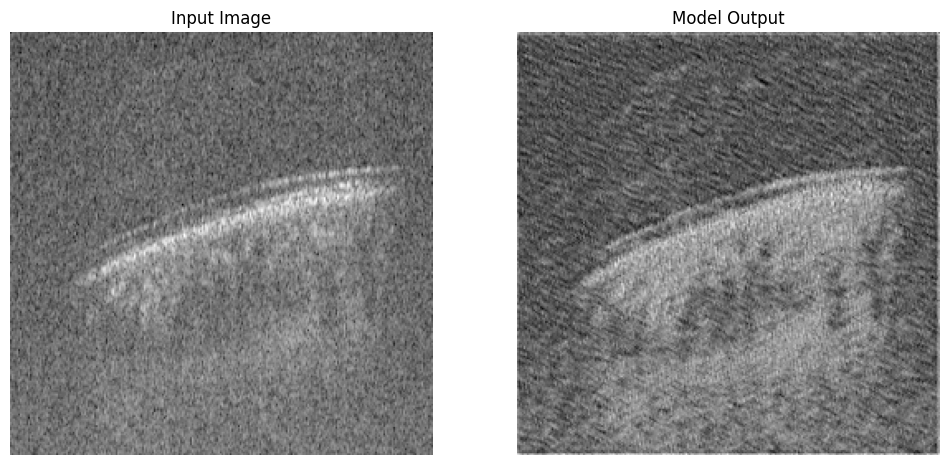

In [ ]:
import matplotlib.pyplot as plt
from ssn2v.stage2.stage_2_dataset import load_data


train_loader, val_loader, test_loader = load_data()

sample = next(iter(train_loader))
print("Sample shape:", sample[0].shape)

with torch.no_grad():
    model.eval()
    output = model(sample[0].to(config["device"]))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(sample[0][0][0].cpu().numpy(), cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(output[0][0].cpu().numpy(), cmap='gray')
plt.title('Model Output')
plt.axis('off')
plt.show()